In [1]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils, plot_model

In [2]:
df = pd.read_csv('fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [4]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}

In [5]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

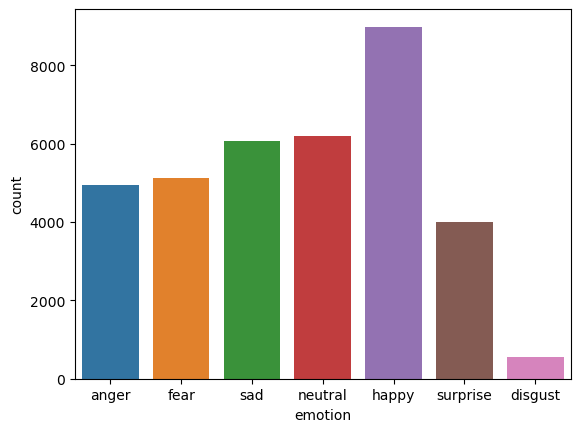

In [6]:
sns.countplot(x=df['emotion'].map(emotion_label_to_text))
pyplot.show()

In [7]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

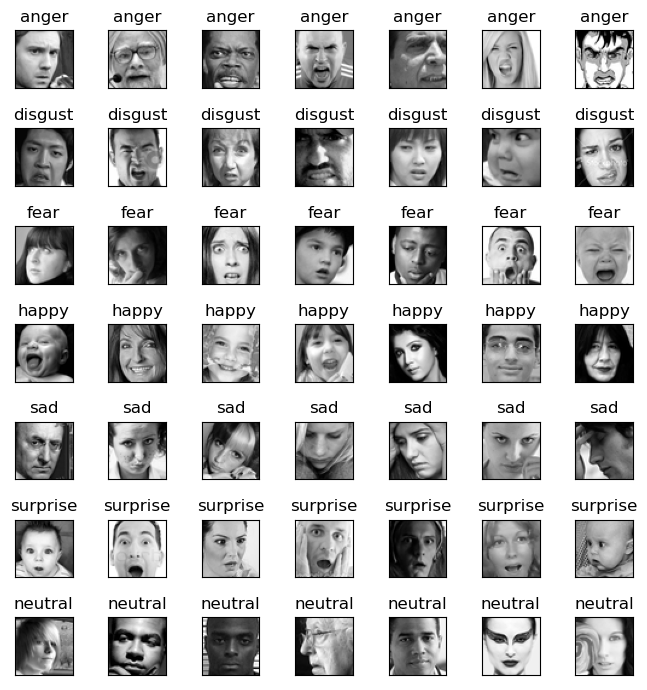

In [8]:
fig = pyplot.figure(1, (7, 7))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [9]:
INTERESTED_LABELS = [3, 4, 6]

In [10]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(21264, 3)

In [11]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [12]:
img_array.shape

(21264, 48, 48, 1)

In [13]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [14]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [16]:
np.sum(y_valid,axis=0)*100/np.sum(y_valid)

array([42.2661  , 28.584862, 29.149036], dtype=float32)

In [17]:
del df
del img_array
del img_labels

In [18]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [19]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [20]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='norm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='norm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='pool-1'))
    net.add(Dropout(0.4, name='drop_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='norm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='norm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='pool_2'))
    net.add(Dropout(0.4, name='drop_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='norm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='norm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='pool_3'))
    net.add(Dropout(0.5, name='drop_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='norm_7'))
    
    net.add(Dropout(0.6, name='drop_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='Out'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [21]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [22]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
trainDS=train_datagen.flow(x=X_train,y=y_train)
validateDS=train_datagen.flow(x=X_valid, y=y_valid)
train_datagen.fit(X_train)



In [23]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1]) 


Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 norm_1 (BatchNormalization)  (None, 48, 48, 64)       256       
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 norm_2 (BatchNormalization)  (None, 48, 48, 64)       256       
                                                                 
 pool-1 (MaxPooling2D)       (None, 24, 24, 64)        0         
                                                                 
 drop_1 (Dropout)            (None, 24, 24, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       73856  

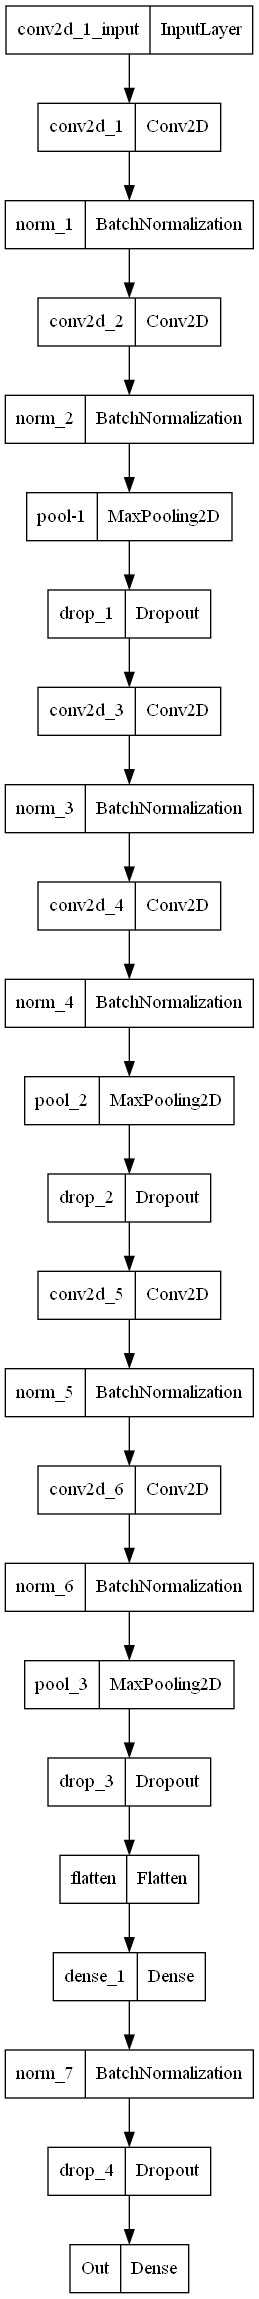

In [24]:
import pydot
import graphviz
plot_model(model, to_file='model.png')

In [25]:
# history = model.fit_generator(
#     train_datagen.flow(X_train, y_train, batch_size=batch_size),
#     validation_data=(X_valid, y_valid),
#     steps_per_epoch=len(X_train) / batch_size,
#     epochs=epochs,
#     callbacks=callbacks,
#     use_multiprocessing=True
# )
history=model.fit (trainDS,validation_data=(X_valid, y_valid),steps_per_epoch=len(X_train) / batch_size,epochs=epochs,callbacks=callbacks)

Epoch 1/100
598/598 [==============================] - 22s 25ms/step - loss: 1.3143 - accuracy: 0.4062 - val_loss: 1.0028 - val_accuracy: 0.5219 - lr: 0.0010
Epoch 2/100
598/598 [==============================] - 15s 24ms/step - loss: 1.0302 - accuracy: 0.4785 - val_loss: 0.8605 - val_accuracy: 0.6037 - lr: 0.0010
Epoch 3/100
598/598 [==============================] - 15s 24ms/step - loss: 0.9228 - accuracy: 0.5496 - val_loss: 0.7710 - val_accuracy: 0.6417 - lr: 0.0010
Epoch 4/100
598/598 [==============================] - 15s 25ms/step - loss: 0.8173 - accuracy: 0.6110 - val_loss: 0.7851 - val_accuracy: 0.6747 - lr: 0.0010
Epoch 5/100
598/598 [==============================] - 15s 25ms/step - loss: 0.7619 - accuracy: 0.6431 - val_loss: 0.6565 - val_accuracy: 0.7203 - lr: 0.0010
Epoch 6/100
598/598 [==============================] - 15s 25ms/step - loss: 0.7223 - accuracy: 0.6720 - val_loss: 0.7192 - val_accuracy: 0.6831 - lr: 0.0010
Epoch 7/100
598/598 [==============================]

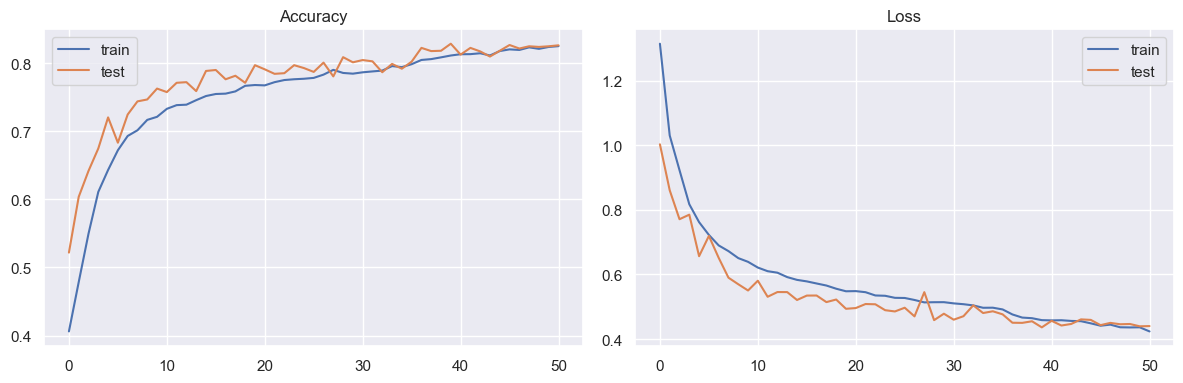

In [28]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.history['accuracy'], label='train')
sns.lineplot(history.history['val_accuracy'], label='test')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.history['loss'], label='train')
sns.lineplot(history.history['val_loss'], label='test')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

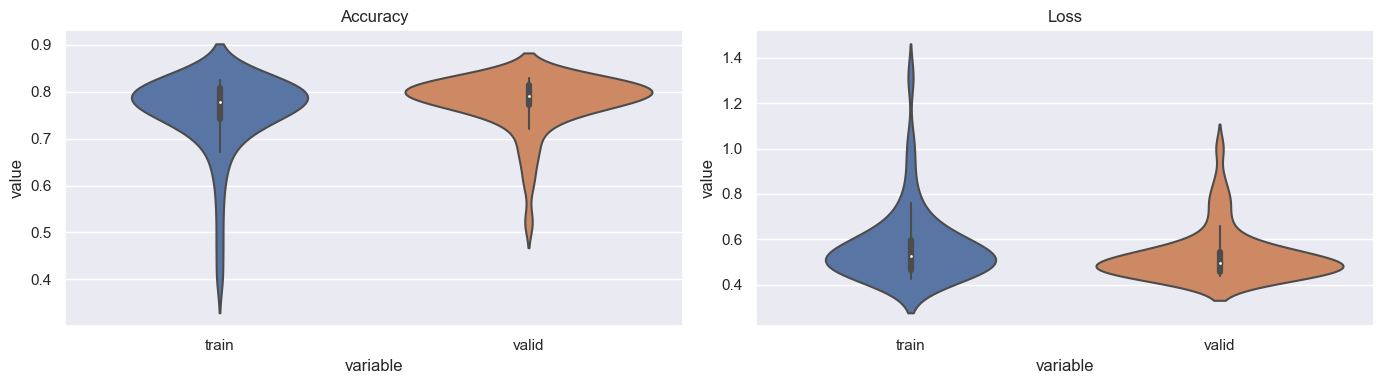

In [27]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

67/67 [==============================] - 1s 11ms/step
total wrong validation predictions: 365


              precision    recall  f1-score   support

           0       0.94      0.92      0.93       899
           1       0.80      0.73      0.76       608
           2       0.71      0.80      0.75       620

    accuracy                           0.83      2127
   macro avg       0.82      0.81      0.81      2127
weighted avg       0.83      0.83      0.83      2127



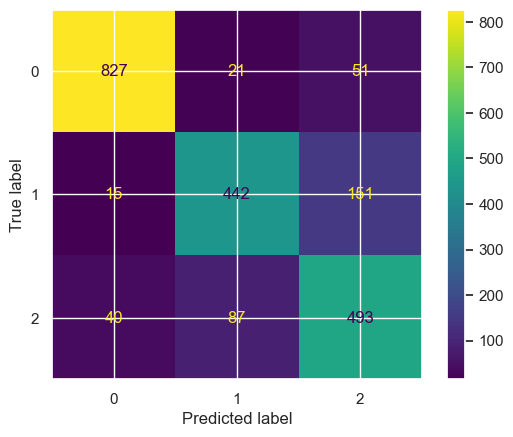

In [34]:
import sklearn
yhat_valid = np.argmax(model.predict(X_valid),axis=-1)
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(np.argmax(y_valid, axis=1), yhat_valid)
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [35]:
model.save('final.h5')